<a href="https://colab.research.google.com/github/sarathsreedharan/CSU_CS_445/blob/main/Spring25/Notebooks/module04_01_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

## Introduction

### First, meet MNIST

<img src="http://www.cs.colostate.edu/~cs445/notebooks/MnistExamples.png" width=500>

The *Modified National Institute of Standards and Technology* database is a large database of handwritten digits.

* Commonly used for training various image processing systems
* A "remix" of the NIST database
    * NIST database training data was taken from American Census Bureau employees;
    * NIST testing data was taken from American high school students.
* Black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, introducing grayscale

MNIST is often a default dataset when teaching convolutional neural nets and other kinds of computer vision systems.  Lots of people use it and so will you!

How many weights are in a fully-connected classification neural network for MNIST digits that has 20 units in one hidden layer and 10 units in the output layer?

If each pixel has a weight in a hidden unit, each unit in hidden layer has 28 x 28 = 784 plus 1 weights, so the hidden layer has (784 + 1) x 20.  The output layer has (20 + 1) x 10 weights.

In [ ]:
(((28*28)+1) * 20) + ((20+1) * 10)

15910

That's quite a few weights.  Can this number be reduced?  Remember, larger numbers of weights probably require more samples to train them.

Well, we could provide each hidden unit with just part of the image, such as a 10 x 10 patch.  We could assign each unit a random patch.  Then we would have (100 + 1) x 20 + 21 * 10 weights.

In [ ]:
(100+1) * 20 + 21 * 10

2230

In [ ]:
2230 / 15910

0.14016341923318668

About $\frac{1}{7}$ the number of weights!

But this assignment of patches to each unit may end up missing parts of an image that are critical for correct classification.  We could add more units to cover more parts, but now our number of weights is growing.  Can we cover more parts of the image without increasing the number of weights in each unit and the number of units?

The answer, no surprise, is yes!  We can create a hidden unit that receives 10 x 10 image patches and apply this unit to all to all 10 x 10 patches from a given image.  Imagine that a unit has a lens that only sees a 10 x 10 patch.  That lens can be shifted around an image, each time passing the viewed patch through the unit and producing a scalar output.  Each of these outputs can be assembled into another image.

For our 10 x 10 unit, this would result in the following process.  Our 28 x 28 image of digits will result in a 2 x 2 set of 10 x 10 non-overlapping patches, with 8 pixels left over on right and bottom parts of the image.  Applying one hidden unit to these four patches produces four outputs that are arranged in a 2 x 2 matrix.  Each of these outputs represents how well the pattern encoded in the unit's weights match the intensities in each patch.

This process of shifting the focus of a unit across an image is a [convolution](https://setosa.io/ev/image-kernels/).  The weights in a hidden unit are often called a kernel or a filter.

With 20 units in the hidden layer, we will have 20 much smaller images produced.  The weights in one unit might be values that result in the largest output when the patch has a vertical edge.  The weights in a second unit might be values that result in the largest output when the patch has a curve like a smile or like the bottom of a hand-drawn digit 3.

We now have a network with 2230 weights that can process an entire image, at the cost of some processing time to do the convolution and some storage for storing the smaller images as the output of a convolutional layer. For our simple example the additional computation and storage cost is small.

What if we allow overlapping patches?  Let's shift, or "stride", the lens of each unit by one pixel left-to-right, and top-to-bottom.  How many patches does this make?  Left-to-right gives us 28 - 10 + 1 = 19 patches, and similarly going top-to-bottom.  So each unit will be applied 19 x 19 times to produce a new image that is 19 x 19 = 361.  

<img style="width:50%;" alt="Convolution example by Irhum Shafkat available at https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1" src="https://miro.medium.com/max/700/1*Fw-ehcNBR9byHtho-Rxbtw.gif">

Anyway, let's move on to some actual examples of images, patches, and convolutions.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#import neuralnetworks_new as nn

import pickle
import gzip

In [ ]:
!wget https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/refs/heads/master/data/mnist.pkl.gz

--2025-03-04 06:22:03--  https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/refs/heads/master/data/mnist.pkl.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17051982 (16M) [application/octet-stream]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  16.26M   105MB/s    in 0.2s    

2025-03-04 06:22:03 (105 MB/s) - ‘mnist.pkl.gz’ saved [17051982/17051982]



In [ ]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0]
Ttrain = train_set[1].reshape(-1, 1)

Xval = valid_set[0]
Tval = valid_set[1].reshape(-1, 1)

Xtest = test_set[0]
Ttest = test_set[1].reshape(-1, 1)

print(Xtrain.shape, Ttrain.shape,  Xval.shape, Tval.shape,  Xtest.shape, Ttest.shape)

(50000, 784) (50000, 1) (10000, 784) (10000, 1) (10000, 784) (10000, 1)


Decode these shapes for me.  How many samples are there total?  How are they represented?  What are the output classes?

These images are grayscale.  How might the representation be different if they were RGB images?

In [ ]:
Ttrain[:10]

array([[5],
       [0],
       [4],
       [1],
       [9],
       [2],
       [1],
       [3],
       [1],
       [4]], dtype=int64)

What does this mean?

In [ ]:
Ttrain[7]

array([3], dtype=int64)

How about this?

In [ ]:
three = Xtrain[7, :].reshape(28, 28)

In [ ]:
plt.imshow?

In [ ]:
def draw_image(image, label):
    plt.imshow(image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(label)

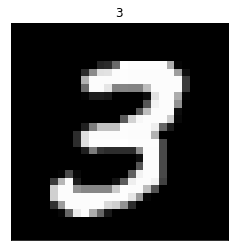

In [ ]:
draw_image(three, 3)

Let's invert the values, so the bright 3 is dark, like an actual pencil drawing.

In [ ]:
def draw_neg_image(image, label):
    plt.imshow(-image, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(label)

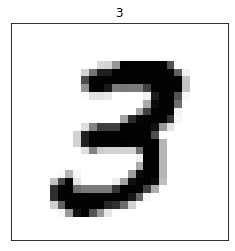

In [ ]:
draw_neg_image(three, 3)

Instead of 10 x 10 patches, let's extract non-overlapping 7 x 7 patches from this image (this is a 28 x 28 image so that will divide nicely).  We can use two for loops: an inner loop to step across columns left-to-right and an outer loop to step down the rows top-to-bottom, and collect each patch into a list called `patches`.

In [ ]:
patches = []
for row in range(0, 28, 7):
    for col in range(0, 28, 7):
        patches.append(three[row:row + 7, col:col + 7])
len(patches)

16

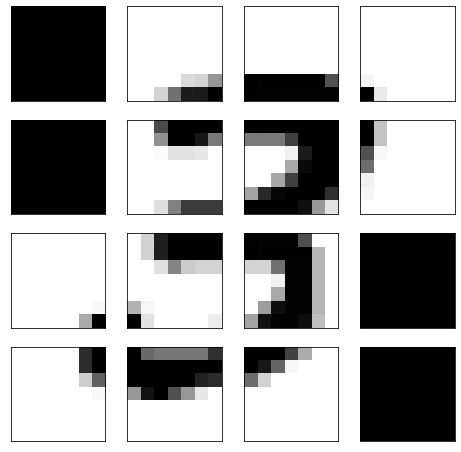

In [ ]:
plt.figure(figsize=(8, 8))
ploti = 0
for patch in patches:
    ploti += 1
    plt.subplot(4, 4, ploti)
    draw_neg_image(patch, '')

Whoops! Some of these patches are all black.

In [ ]:
def draw_neg_image(image, label):
    plt.imshow(-image, cmap='gray', vmin=-1, vmax=0)  # <-- New part
    plt.xticks([])
    plt.yticks([])
    plt.title(label)

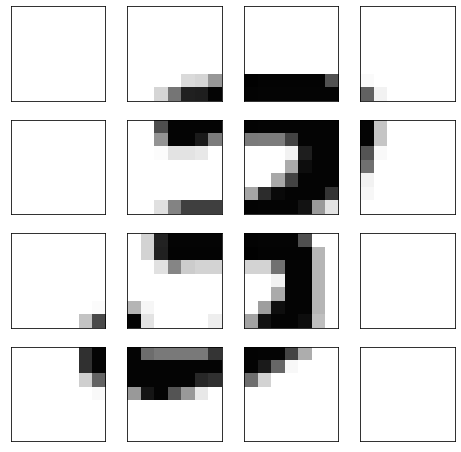

In [ ]:
plt.figure(figsize=(8, 8))
ploti = 0
for patch in patches:
    ploti += 1
    plt.subplot(4, 4, ploti)
    draw_neg_image(patch, '')

Those all black patches are because all intensities there are 0.  Fix this by specifying min and max values to coloring each image.

What if we want some overlap?  7 x 7 patches that shift by 2 columns and 2 rows.

In [ ]:
patches = []
for row in range(0, 28, 2):
    for col in range(0, 28, 2):
        patches.append(three[row:row + 7, col:col + 7])
len(patches)

196

In [ ]:
np.sqrt(len(patches))

14.0

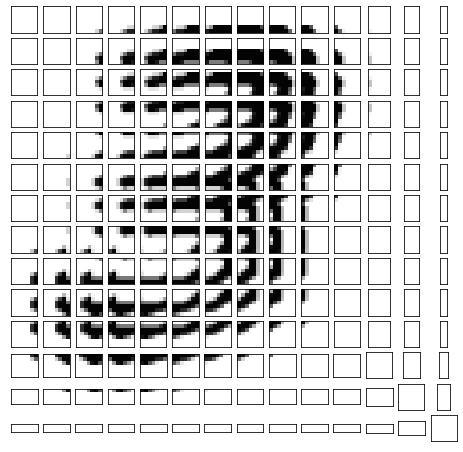

In [ ]:
n_plot_rows = int(np.sqrt(len(patches)))
plt.figure(figsize=(8, 8))
ploti = 0
for patch in patches:
    ploti += 1
    plt.subplot(n_plot_rows, n_plot_rows, ploti)
    draw_neg_image(patch, '')

We will need all patches to be the same size, so we must discard the smaller ones on the right and the bottom.  Alternatively, we can pad the original image to guarantee all patches are the same size.

In [ ]:
patches = []
for row in range(0, 28, 2):
    for col in range(0, 28, 2):
        if row + 7 < 28 and col + 7 < 28: # cropping solution, not padding solution
            patches.append(three[row:row + 7, col:col + 7])
len(patches)

121

In [ ]:
np.sqrt(len(patches))

11.0

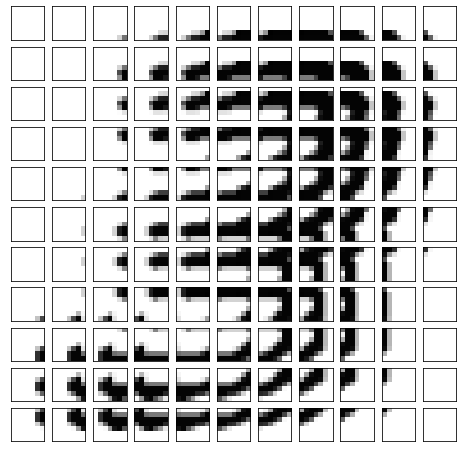

In [ ]:
n_plot_rows = int(np.sqrt(len(patches)))
plt.figure(figsize=(8, 8))
ploti = 0
for patch in patches:
    ploti += 1
    plt.subplot(n_plot_rows, n_plot_rows, ploti)
    draw_neg_image(patch, '')

Are these patches using lots of storage, or are they just views onto the original image array?  Hopefully they are just views.  Test this by modifying the original image in the upper left corner and that redrawing the patches.

In [ ]:
three[0:4, 0:4] # look at the first 4 rows and columns of our "three" data matrix

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [ ]:
three[0:4, 0:4] = 1.0
three[0:5, 0:5]

array([[1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

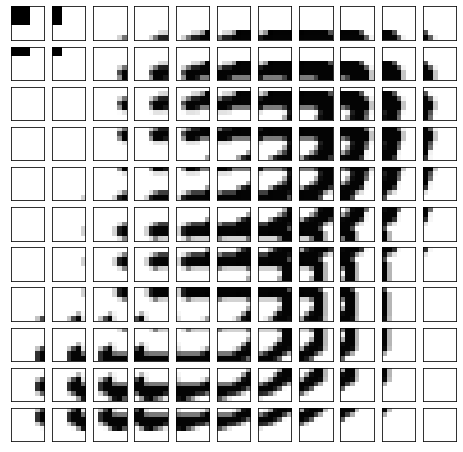

In [ ]:
n_plot_rows = int(np.sqrt(len(patches)))
plt.figure(figsize=(8, 8))
ploti = 0
for patch in patches:
    ploti += 1
    plt.subplot(n_plot_rows, n_plot_rows, ploti)
    draw_neg_image(patch, '')

Yep, just views. Good!

Now let's reset those pixels.

In [ ]:
three[0:4, 0:4] = 0.0

## Weight matrix as kernel or filter

Now, how would we create a unit as a kernel or filter and apply it to all patches?  

It is just a 7 x 7 matrix.  Let's make one that detects diagonal edges from lower left to upper right.

In [ ]:
weights = np.array([[-1, -1, -1, -1, -1, -1, -1],
                    [-1, -1, -1, -1, -1, -1,  1],
                    [-1, -1, -1, -1, -1,  1,  1],
                    [-1, -1, -1, -1,  1,  1,  1],
                    [-1, -1, -1,  1,  1,  1,  1],
                    [-1, -1,  1,  1,  1,  1,  1],
                    [-1,  1,  1,  1,  1,  1,  1]])
weights

array([[-1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1,  1],
       [-1, -1, -1, -1, -1,  1,  1],
       [-1, -1, -1, -1,  1,  1,  1],
       [-1, -1, -1,  1,  1,  1,  1],
       [-1, -1,  1,  1,  1,  1,  1],
       [-1,  1,  1,  1,  1,  1,  1]])

Let's talk about how this matrix (filter) detects edges.  Both this filter and the image patch are 7 x 7 matrices, so they'll multiply together. The -1s will negate or deemphasize the values on one (the "negative") side of the edge while the 1s emphasize the values on the "positive" side of the edge.  What if the patch is all 0s?

In [ ]:
imgs = [] # store these experiments for plotting

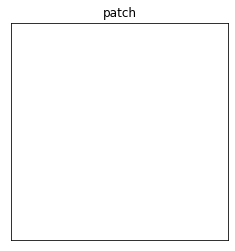

In [ ]:
patch = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0]])
imgs.append(patch)
draw_neg_image(patch, 'patch')

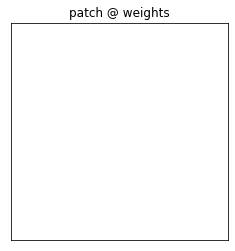

In [ ]:
imgs.append(patch @ weights)
draw_neg_image(patch @ weights, 'patch @ weights')

What about if the patch is all 1s?

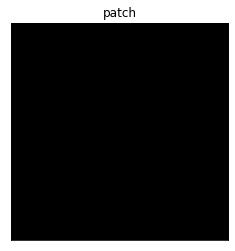

In [ ]:
patch = np.array([[1, 1, 1, 1, 1, 1, 1],
                  [1, 1, 1, 1, 1, 1, 1],
                  [1, 1, 1, 1, 1, 1, 1],
                  [1, 1, 1, 1, 1, 1, 1],
                  [1, 1, 1, 1, 1, 1, 1],
                  [1, 1, 1, 1, 1, 1, 1],
                  [1, 1, 1, 1, 1, 1, 1]])
imgs.append(patch)
draw_neg_image(patch, 'patch')

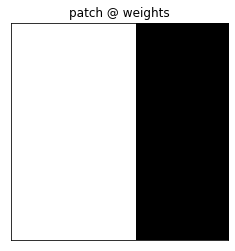

In [ ]:
imgs.append(patch @ weights)
draw_neg_image(patch @ weights, 'patch @ weights')

How about this checkerboard pattern?

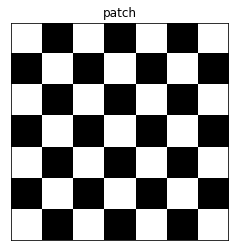

In [ ]:
patch = np.array([[0, 1, 0, 1, 0, 1, 0],
                  [1, 0, 1, 0, 1, 0, 1],
                  [0, 1, 0, 1, 0, 1, 0],
                  [1, 0, 1, 0, 1, 0, 1],
                  [0, 1, 0, 1, 0, 1, 0],
                  [1, 0, 1, 0, 1, 0, 1],
                  [0, 1, 0, 1, 0, 1, 0]])
imgs.append(patch)
draw_neg_image(patch, 'patch')

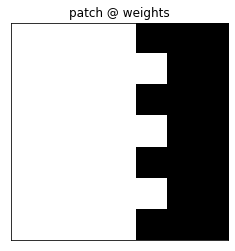

In [ ]:
imgs.append(patch @ weights)
draw_neg_image(patch @ weights, 'patch @ weights')

What if the patch actually contains an edge from bottom left to top right?

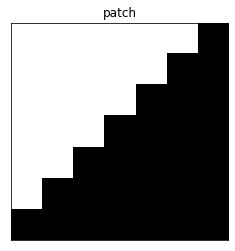

In [ ]:
patch = np.array([[0, 0, 0, 0, 0, 0, 1],
                  [0, 0, 0, 0, 0, 1, 1],
                  [0, 0, 0, 0, 1, 1, 1],
                  [0, 0, 0, 1, 1, 1, 1],
                  [0, 0, 1, 1, 1, 1, 1],
                  [0, 1, 1, 1, 1, 1, 1],
                  [1, 1, 1, 1, 1, 1, 1]])
imgs.append(patch)
draw_neg_image(patch, 'patch')

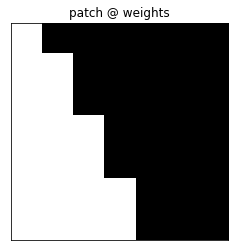

In [ ]:
imgs.append(patch @ weights)
draw_neg_image(patch @ weights, 'patch @ weights')

What about the reverse?

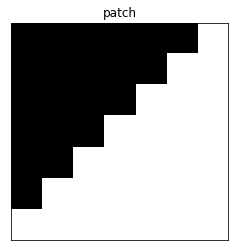

In [ ]:
patch = np.array([[1, 1, 1, 1, 1, 1, 0],
                  [1, 1, 1, 1, 1, 0, 0],
                  [1, 1, 1, 1, 0, 0, 0],
                  [1, 1, 1, 0, 0, 0, 0],
                  [1, 1, 0, 0, 0, 0, 0],
                  [1, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0]])
imgs.append(patch)
draw_neg_image(patch, 'patch')

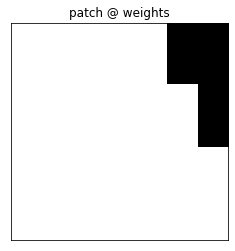

In [ ]:
imgs.append(patch @ weights)
draw_neg_image(patch @ weights, 'patch @ weights')

OK, one more.

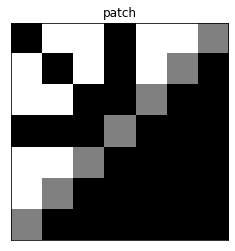

In [ ]:
patch = np.array([[1, 0, 0, 1, 0, 0, 0.5],
                  [0, 1, 0, 1, 0, 0.5, 1],
                  [0, 0, 1, 1, 0.5, 1, 1],
                  [1, 1, 1, 0.5, 1, 1, 1],
                  [0, 0, 0.5, 1, 1, 1, 1],
                  [0, 0.5, 1, 1, 1, 1, 1],
                  [0.5, 1, 1, 1, 1, 1, 1]])
imgs.append(patch)
draw_neg_image(patch, 'patch')

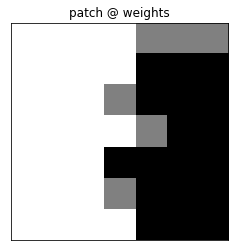

In [ ]:
imgs.append(patch @ weights)
draw_neg_image(patch @ weights, 'patch @ weights')

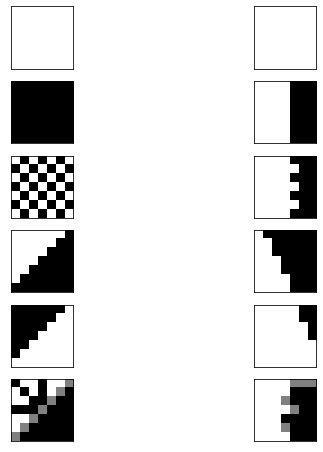

In [ ]:
plt.figure(figsize=(8, 8))
ploti = 0
for img in imgs:
    ploti += 1
    plt.subplot(int(len(imgs)/2), 2, ploti)
    draw_neg_image(img, '')

`patch @ weights` here isn't in and of itself meaningful, but the more positive values in the matrix that's created when you multiply the patch by the filter (i.e., the more black in the image in the right column), the greater positive value that patch will output when multiplied by the filter.

If the filter defines a bottom left-to-top right edge, only one of those patches looks like it should produce a very positive value (i.e., `patch @ weights` here is mostly black).  Which one is that?

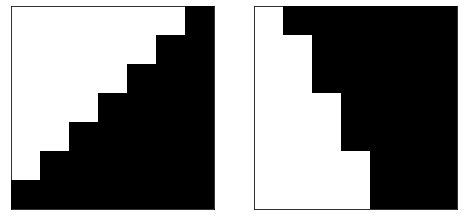

In [ ]:
plt.figure(figsize=(8, 8))
ploti = 0
for img in imgs[6:8]:
    ploti += 1
    plt.subplot(1, 2, ploti)
    draw_neg_image(img, '')

This patch has a well-defined edge.  When multiplied by our "edge" filter, it should output a very positive value (sum all the values in `patch @ weights` to get a single value).

Let's look at our "3" patches again.

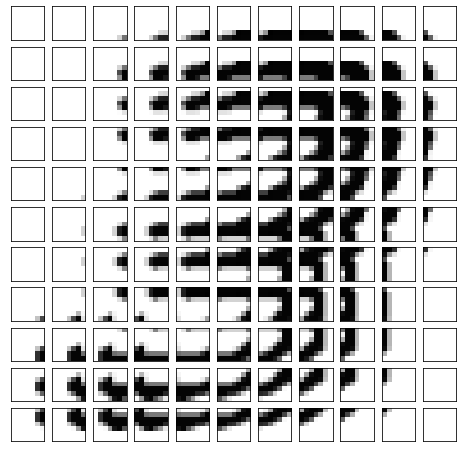

In [ ]:
n_plot_rows = int(np.sqrt(len(patches)))
plt.figure(figsize=(8, 8))
ploti = 0
for patch in patches:
    ploti += 1
    plt.subplot(n_plot_rows, n_plot_rows, ploti)
    draw_neg_image(patch, '')

OK, so which of the above patches do you think will result in large positive values and large negative values when we apply our "edge" filter.

Let's apply this filter to all of the patches.  To do this, we just need to multiply the intensities in a patch by the corresponding weight and sum them up.

In [ ]:
new_image = []
for patch in patches:
    new_image.append(np.sum(patch * weights))
new_image = np.array(new_image)
new_image

array([  0.        ,   0.        ,   0.7109375 ,   2.78515625,
         6.1640625 ,   8.55859375,   9.3984375 ,   7.56640625,
         4.328125  ,   0.3828125 ,  -1.015625  ,   0.        ,
         0.        ,   3.80078125,   9.7265625 ,  13.00390625,
         9.80859375,   7.33203125,   6.828125  ,   3.02734375,
        -2.53125   ,  -3.8671875 ,   0.        ,   0.        ,
         3.9296875 ,   6.953125  ,   1.87890625,  -5.94140625,
        -4.44921875,  -0.90625   ,  -2.390625  , -10.3515625 ,
        -8.80859375,   0.        ,   0.        ,   1.1171875 ,
        -3.37109375, -10.13671875, -11.8671875 ,  -4.65234375,
         2.14453125,  -8.50390625, -17.91015625, -11.0859375 ,
         0.        ,   0.17578125,   1.328125  ,   2.67578125,
         4.921875  ,   5.38671875,  10.796875  ,   2.0703125 ,
       -14.62890625, -18.84765625,  -7.41015625,   0.        ,
         0.3515625 ,   5.27734375,  10.50390625,   8.62109375,
         6.91796875,   4.390625  ,  -7.3515625 , -17.42

Bleech.  Can't understand that.  Let's make it into an image and draw it.

In [ ]:
new_image_dim = int(np.sqrt(len(new_image)))
new_image_dim

11

Recall, there are 121 patches in our 28 x 28 images using 7 x 7 patch size with a stride length of 2, after cropping all non 7 x 7 patches, so we have 11 patches x 11 patches.

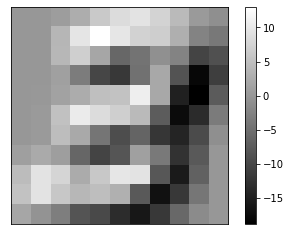

In [ ]:
new_image = new_image.reshape(new_image_dim, new_image_dim)
draw_image(new_image, '')
plt.colorbar();

We can apply our weights filter to all of the patches with one matrix multiplication!

In [ ]:
new_image.shape

(11, 11)

In [ ]:
len(patches), patches[0].shape

(121, (7, 7))

In [ ]:
patches_array = np.array(patches)
patches_array.shape

(121, 7, 7)

In [ ]:
weights.shape

(7, 7)

In [ ]:
patches_array.reshape(121, -1).shape

(121, 49)

In [ ]:
weights.reshape(-1, 1).shape

(49, 1)

In [ ]:
new_image = patches_array.reshape(121, -1) @ weights.reshape(-1, 1)
new_image.shape

(121, 1)

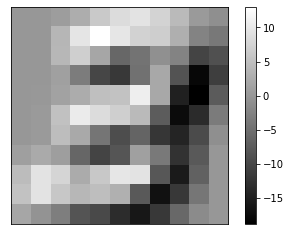

In [ ]:
new_image = new_image.reshape(new_image_dim, new_image_dim)
draw_image(new_image, '')
plt.colorbar();

Now, the idea is to come up with a number of such weight matrices to use as filters that extract the features of the image that are useful for classifying the digit.  How can we do this?

Above we defined a filter that would detect bottom left-top right edges. But how could we *learn* this weight matrix?

Each unit in the hidden layer is a convolutional unit with a 7 x 7 weight matrix, plus 1 weight for the constant 1 input.  We can just backpropagate an error from the output layer through the hidden convolutional layer to update each unit's weights, as we have been doing all along!

Backpropagation through a convolutional layer is tricky, because each unit is applied multiple times to all of the patches and we must sum up all of the resulting weight changes resulting from applying a unit to each patch.  This sum is then used to make the update to the weights.

Before we jump into code for doing this, let's revisit the method for dividing an image up into patches. We used two nested for loops, and we know for loops in Python are slow.  Since convolution is a common procedure for many signal and image processing applications, the `numpy` function `np.lib.as_strided` function is available to do this. Thank the numpy developers! See [Using stride tricks with NumPy](https://ipython-books.github.io/46-using-stride-tricks-with-numpy/) for an example use.

In [ ]:
import numpy.lib.stride_tricks

def make_patches(X, patch_size, stride=1):
    '''X: n_samples x n_pixels  (flattened square images)'''
    X = np.ascontiguousarray(X)  # make sure X values are contiguous in memory

    n_samples = X.shape[0]
    image_size = int(np.sqrt(X.shape[1]))
    n_patches = (image_size - patch_size ) // stride + 1

    nb = X.itemsize  # number of bytes each value

    new_shape = [n_samples, n_patches, n_patches, patch_size, patch_size]
    new_strides = [image_size * image_size * nb,
                   image_size * stride * nb,
                   stride * nb,
                   image_size * nb,
                   nb]
    X = np.lib.stride_tricks.as_strided(X, shape=new_shape, strides=new_strides)
    X = X.reshape(n_samples, n_patches * n_patches, patch_size * patch_size)
    return X

In [ ]:
Xtrain.shape

(50000, 784)

In [ ]:
patches = make_patches(Xtrain[:2], 7, 2)

In [ ]:
patches.shape

(2, 121, 49)

[5]
[0]


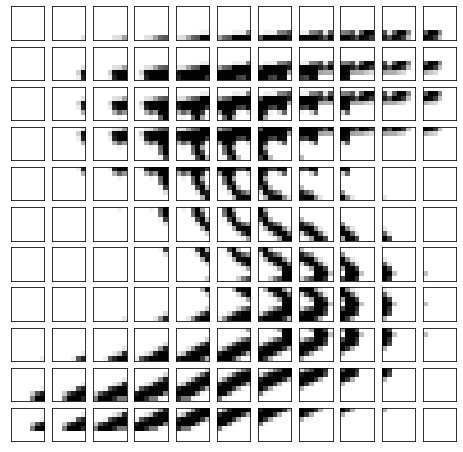

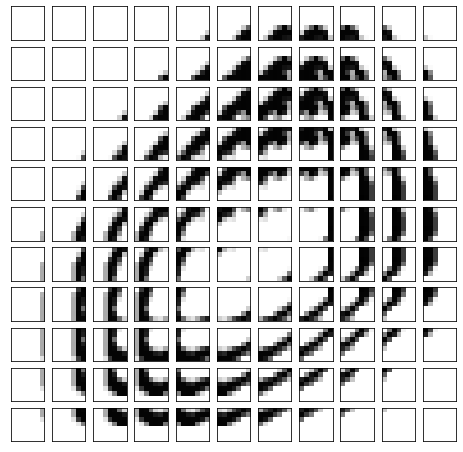

In [ ]:
n_plot_rows = int(np.sqrt(patches.shape[1]))
patch_size = int(np.sqrt(patches.shape[2]))

for patchi in range(patches.shape[0]):
    print(Ttrain[patchi])
    plt.figure(figsize=(8, 8))
    ploti = 0
    for patch in patches[patchi, :, :]:
        ploti += 1
        plt.subplot(n_plot_rows, n_plot_rows, ploti)
        draw_neg_image(patch.reshape(patch_size, patch_size), '')

In [ ]:
weights.shape

(7, 7)

In [ ]:
weights = weights.reshape((49, 1))
weights.shape

(49, 1)

In [ ]:
patches.shape

(2, 121, 49)

Let's make two filters!  One will detect bottom left-to-top right edges.  The other will detect top left-to-bottom right edges.

In [ ]:
weights = np.hstack((weights, weights)) # copy the weights into two identical columns

In [ ]:
weights[:, 0].reshape(7,7)

array([[-1, -1, -1, -1, -1, -1, -1],
       [-1, -1, -1, -1, -1, -1,  1],
       [-1, -1, -1, -1, -1,  1,  1],
       [-1, -1, -1, -1,  1,  1,  1],
       [-1, -1, -1,  1,  1,  1,  1],
       [-1, -1,  1,  1,  1,  1,  1],
       [-1,  1,  1,  1,  1,  1,  1]])

In [ ]:
# redefine the second column to represent the new filter
weights[:, 1] = np.array([[-1, 1, 1, 1, 1, 1, 1],
                          [-1, -1, 1, 1, 1, 1, 1],
                          [-1, -1, -1, 1, 1, 1, 1],
                          [-1, -1, -1, -1, 1, 1, 1],
                          [-1, -1, -1, -1, -1, 1, 1],
                          [-1, -1, -1, -1, -1, -1, 1],
                          [-1, -1, -1, -1, -1, -1, -1]]).reshape(49)

In [ ]:
weights[:, 1].reshape(7,7)

array([[-1,  1,  1,  1,  1,  1,  1],
       [-1, -1,  1,  1,  1,  1,  1],
       [-1, -1, -1,  1,  1,  1,  1],
       [-1, -1, -1, -1,  1,  1,  1],
       [-1, -1, -1, -1, -1,  1,  1],
       [-1, -1, -1, -1, -1, -1,  1],
       [-1, -1, -1, -1, -1, -1, -1]])

In [ ]:
output = patches @ weights
output.shape

(2, 121, 2)

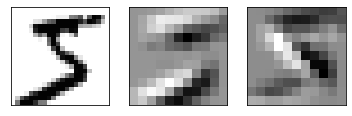

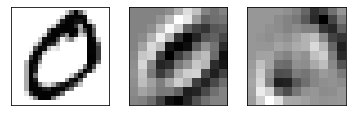

In [ ]:
for i in range(2):
    plt.figure()
    for j in range(3):
        plt.subplot(1, 3, j+1)
        if (j < 1):
            draw_neg_image(Xtrain[i].reshape(28, 28)[3:25,3:25], '') # draw the original image (crop to fit)
        else:
            output_image = output[i, :, j-1].reshape(11, 11)
            draw_image(output_image, '') # draw the patches @ filters